<a href="https://colab.research.google.com/github/ziatdinovmax/pycroscopy/blob/phoenix/examples/notebooks/PycroscopyDenosingAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders for Image Cleaning

*  *Notebook prepared by Maxim Ziatdinov  (email: ziatdinovmax@gmail.com)*

*  *The simulated data (atomic coordinates) comes from MD calculations by Bobby Sumpter and Ayana Ghosh*

*  *Experimental (validation) data by Ondrej Dyck*



---


This notebook provides an example of training a Denoising Autoencoder for simple image cleaning using Pycroscopy's DL module. Generally, autoencoders refer to the class of the neural networks that compress the data set to a small number of bottleneck features, and then expand back to original data size. The training aims to minimize information loss between the initial and reconstructed images via usual backpropagation. This process tends to select the relevant features in the data set and reject the noise, giving rise to applications for denoising.


---







Installation:

In [1]:
!git clone -b phoenix --single-branch https://github.com/pycroscopy/pycroscopy  # To be replaced with pip install once there is a stable version
%cd pycroscopy/

Cloning into 'pycroscopy'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 21581 (delta 85), reused 129 (delta 31), pack-reused 21390
Receiving objects: 100% (21581/21581), 316.45 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (15743/15743), done.
/content/pycroscopy


Imports:

In [2]:
import pycroscopy as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Down(load) simulated data of graphene:

In [3]:
# Download into VM storage
!wget -O "graphene_MD_imgs.npy" https://www.dropbox.com/s/r2cz8jqc9m19gaj/cropped_images_new.npy?dl=1

--2021-03-19 20:28:05--  https://www.dropbox.com/s/r2cz8jqc9m19gaj/cropped_images_new.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/r2cz8jqc9m19gaj/cropped_images_new.npy [following]
--2021-03-19 20:28:05--  https://www.dropbox.com/s/dl/r2cz8jqc9m19gaj/cropped_images_new.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce59d3b2ad3378db72b33aae7ca.dl.dropboxusercontent.com/cd/0/get/BLCNBJ0Xnl5iSQzWVDGB_tHdeklRZFwIRqXtCY-YGuWWp2LJi-3Upd9w97EwlqDIYPrU27tzXOwEJxSqId7v76LYnT2FzMR6yGeJ55DGBE_Fz141iKwafIhCNh3dIW-dNdroU730WNKsMPcSjwDx8uXv/file?dl=1# [following]
--2021-03-19 20:28:06--  https://uce59d3b2ad3378db72b33aae7ca.dl.dropboxusercontent.com/cd/0/get/BLCNBJ0Xnl5iSQzWVDGB_tHdeklRZFwIRqXtCY-YGuWWp2LJi-3Upd9

Load data into the notebook:


In [4]:
imgdata = np.load("graphene_MD_imgs.npy")[::3] # take ~1/3 of the data
print(imgdata.shape)

(2016, 256, 256)


Now let's corrupt our data with noise and then use a denoising autoencoder to reconstruct the original images.

In [5]:
np.random.seed(42) # for reproducibility
# Add noise to data
imgdata_noisy = imgdata + np.random.normal(scale=8, size=imgdata.shape)

View selected pairs of images (images from the left subplot will be inputs into a neural network and images from the right subplot will be our targets)

Text(0.5, 1.0, 'Original image')

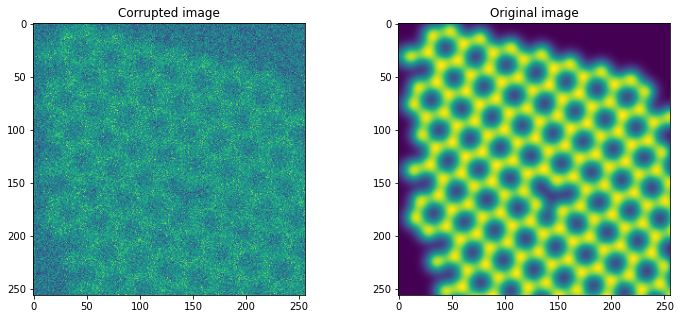

In [6]:
k = 15

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata_noisy[k])
ax2.imshow(imgdata[k])
ax1.set_title("Corrupted image")
ax2.set_title("Original image")

A neural network takes a 4D tensor (*n_samples, n_channels, height, width*) as an input where the second dimension is a number of channels. This dimension needs to specified explicitly even if you have only one channel (i.e., you are working with grayscale images). This can be easily done using NumPy's ```np.expand_dims(your_array, 1)``` command or just ```your_array[:, None]```.

In [7]:
imgdata = imgdata[:, None]
imgdata_noisy = imgdata_noisy[:, None]

Split model into train and test sets using a standard *sklearn* function:

In [8]:
data_split = train_test_split(imgdata_noisy, imgdata, test_size=0.2, random_state=1)
imgdata_noisy, imgdata_noisy_test, imgdata, imgdata_test = data_split

Initialize our denosing autoencoder:

In [9]:
model = px.learn.dl.models.DenoisingAutoEncoder(ndim=2, batchnorm=False)  # consider setting batchnorm to True if training becomes unstable
print(model)

DenoisingAutoEncoder(
  (encoder): FeatureExtractor(
    (c0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (c1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (c2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negati

Train it for 20 epochs:

In [10]:
# Initialize trainer
trainer = px.learn.Trainer(
    model, # our initialized model
    imgdata_noisy, imgdata, imgdata_noisy_test, imgdata_test,  # train and test data
    batch_size=64  # batch size
)
# Train for 20 epochs
trainer.fit(num_epochs=20)

Epoch: 1... Training loss: 44.9096... Test loss: 19.9743
Epoch: 2... Training loss: 20.2087... Test loss: 15.6786
Epoch: 3... Training loss: 10.7083... Test loss: 5.4988
Epoch: 4... Training loss: 4.2213... Test loss: 3.2833
Epoch: 5... Training loss: 2.8451... Test loss: 2.3343
Epoch: 6... Training loss: 2.1457... Test loss: 1.7723
Epoch: 7... Training loss: 1.5811... Test loss: 1.3671
Epoch: 8... Training loss: 1.6015... Test loss: 1.1947
Epoch: 9... Training loss: 1.1573... Test loss: 0.9795
Epoch: 10... Training loss: 0.9968... Test loss: 0.9733
Epoch: 11... Training loss: 0.9834... Test loss: 0.9294
Epoch: 12... Training loss: 0.7927... Test loss: 0.7284
Epoch: 13... Training loss: 0.7194... Test loss: 0.7425
Epoch: 14... Training loss: 0.7701... Test loss: 1.1028
Epoch: 15... Training loss: 1.7580... Test loss: 1.4173
Epoch: 16... Training loss: 0.9316... Test loss: 0.7047
Epoch: 17... Training loss: 0.6259... Test loss: 0.5943
Epoch: 18... Training loss: 0.5754... Test loss: 0.5

Plot training/test loss history:

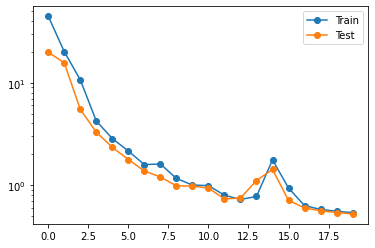

In [11]:
plt.plot(trainer.train_losses, '-o', label='Train')
plt.plot(trainer.test_losses, '-o', label='Test')
plt.yscale("log")
plt.legend();

Use the trained model to clean the test data:

In [12]:
prediction = model.predict(imgdata_noisy_test)

View the predictions:

(note that here we are using the NumPy's ```squeeze``` method to automatically get rid of a single channel dimension in the output)

Text(0.5, 1.0, 'Original image')

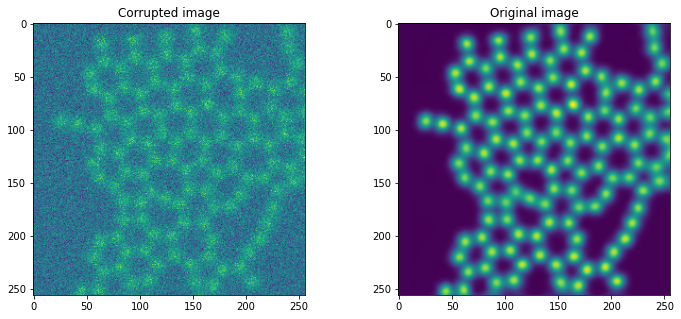

In [13]:
k = 15

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata_noisy_test[k,0])
ax2.imshow(prediction[k].squeeze())
ax1.set_title("Corrupted image")
ax2.set_title("Original image")

Now we are going to gradually increase the noise level and see how well our model can generalize:

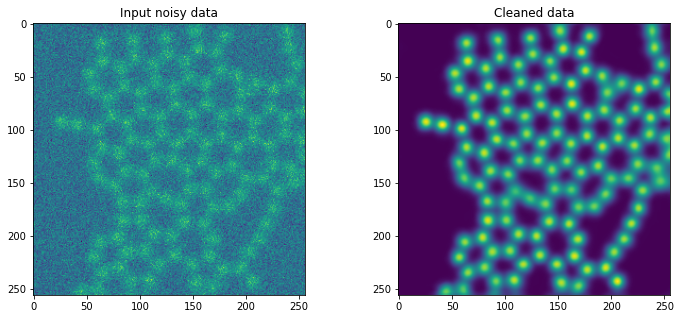

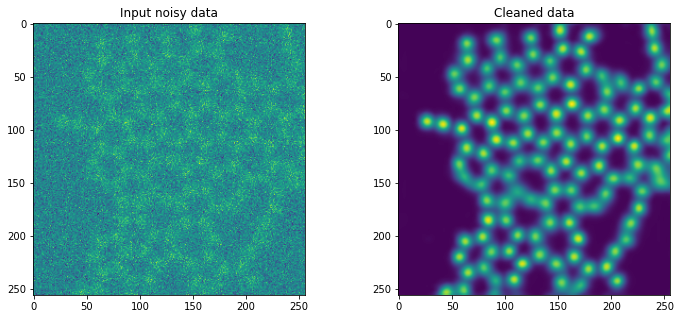

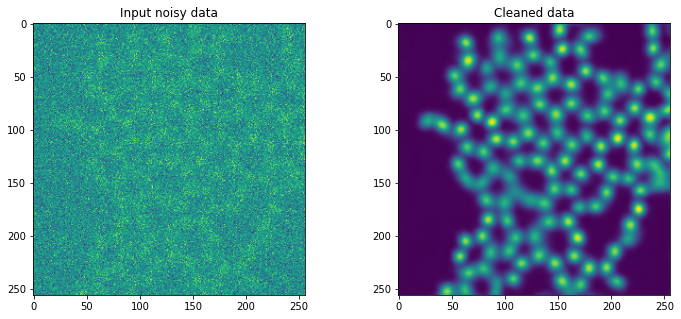

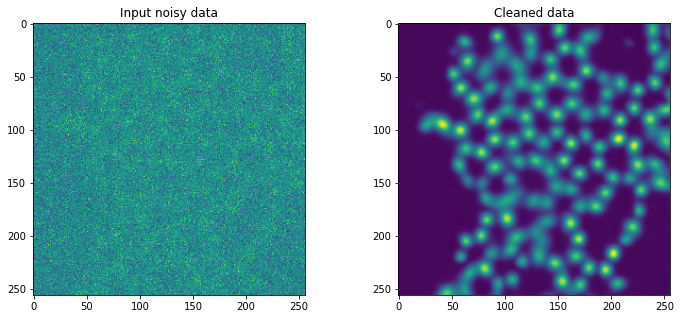

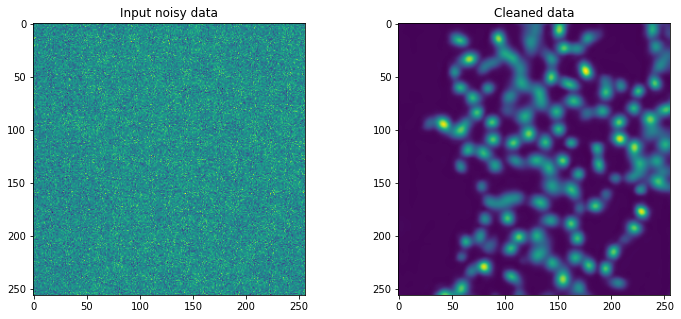

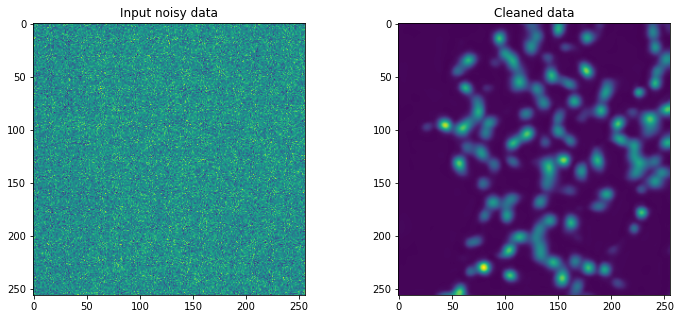

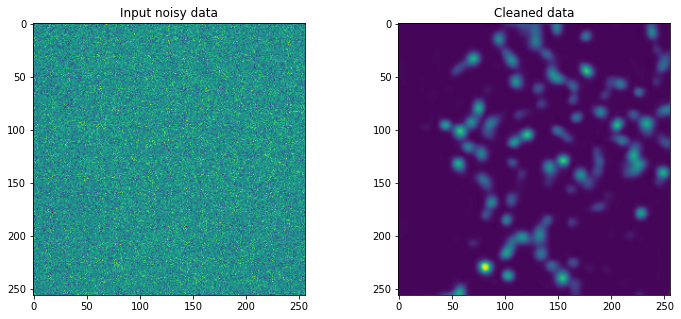

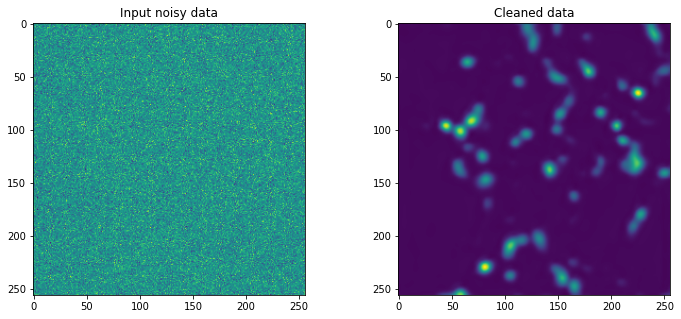

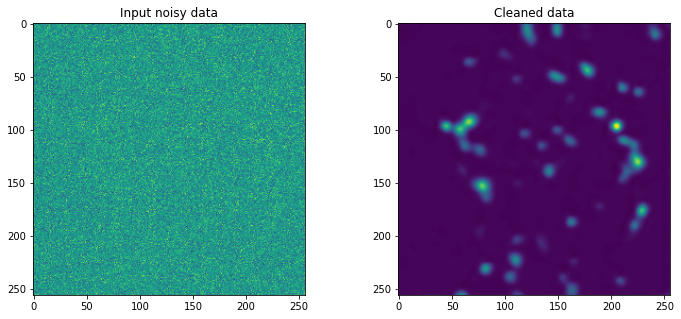

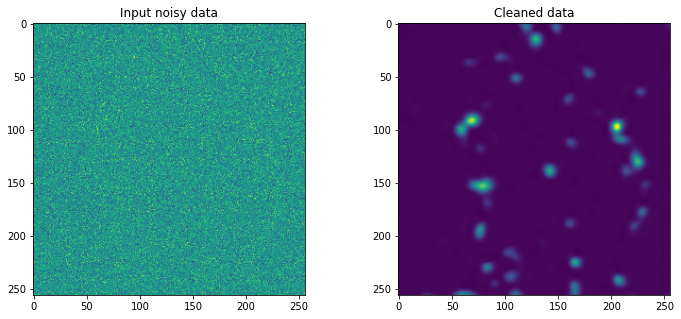

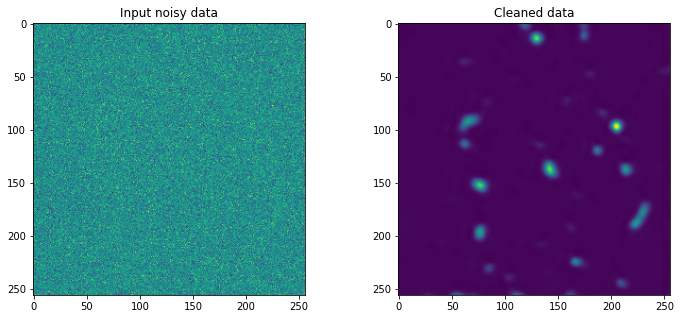

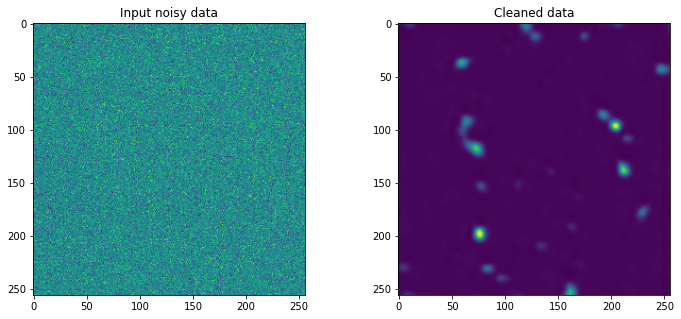

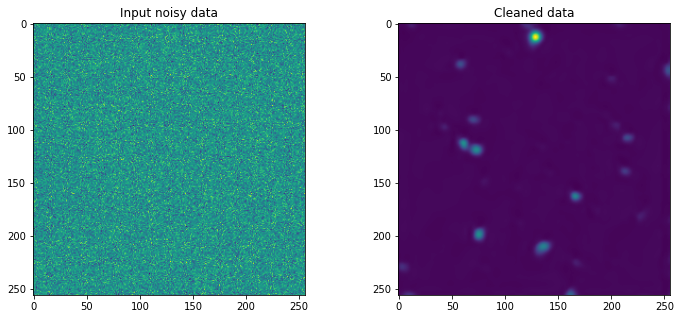

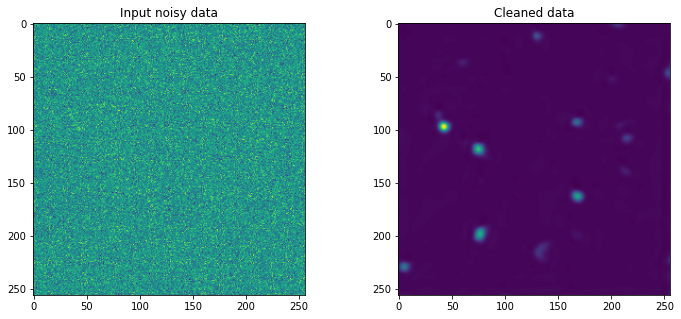

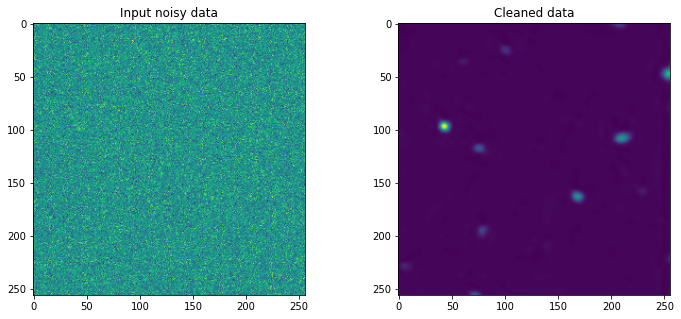

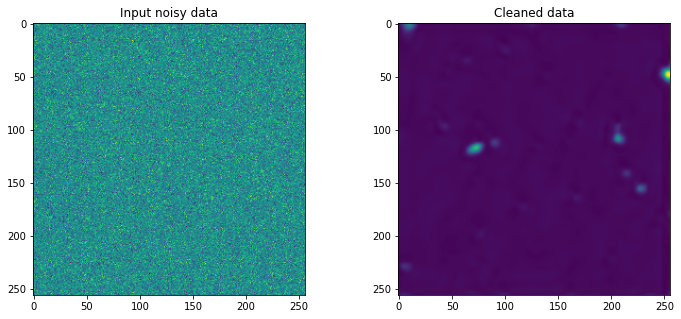

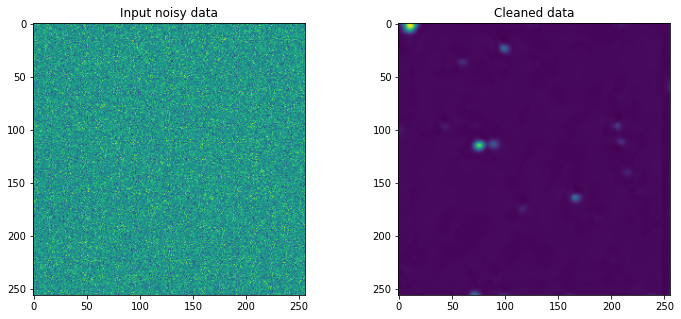

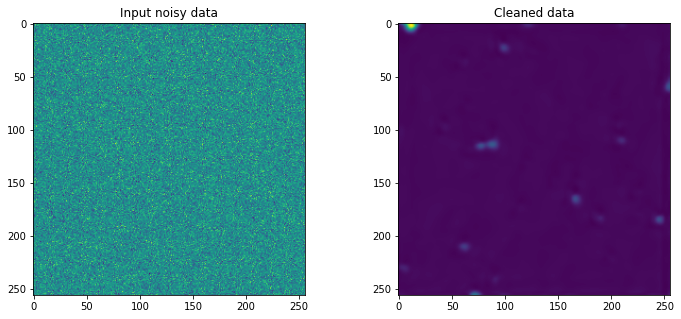

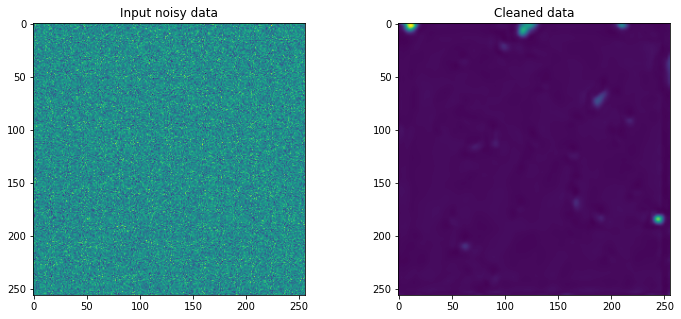

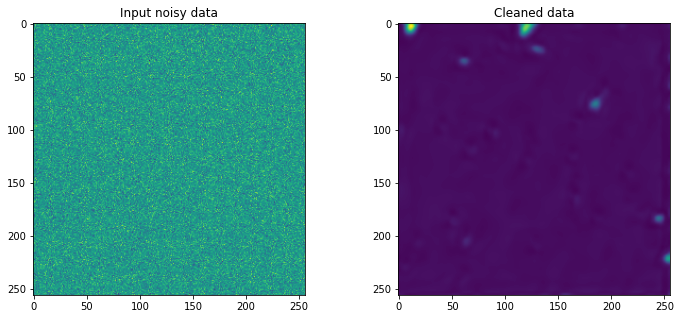

In [14]:
img = imgdata_test[k:k+1]
for s in range(0, 100, 5):
    img = img + np.random.normal(scale=8+s, size=img.shape)
    prediction = model.predict(img)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img[0,0])
    ax2.imshow(prediction.squeeze())
    ax1.set_title("Input noisy data")
    ax2.set_title("Cleaned data")
    plt.show()

Finally, let's apply it to experimental data. Note that the current model is by no means optimized to work with experimental data - we didn't even consider any scale changes. Still, it is interesting to see how it will perform on real-world data.

In [15]:
# download data
!wget -O "graphene_exp.npy" https://www.dropbox.com/s/33uo35z4siiy2y4/Gr_SiCr.npy?dl=1

--2021-03-19 20:32:02--  https://www.dropbox.com/s/33uo35z4siiy2y4/Gr_SiCr.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/33uo35z4siiy2y4/Gr_SiCr.npy [following]
--2021-03-19 20:32:03--  https://www.dropbox.com/s/dl/33uo35z4siiy2y4/Gr_SiCr.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc74479041c02a0736ceaefb9c17.dl.dropboxusercontent.com/cd/0/get/BLD05JCWkasuivMoW6ZZg4XwGYw8XM0y2U9lSAj78HJSosy_lc5bIb_qxc0IN99foawdpnUmB_YQQq_k6P_IMywQ4TgiQ0sYNy2F03gQlPDYBiy1NRK4oQ0QTjUrZzZ0xN2jcUeoMO2wCFQdo3V97Ovd/file?dl=1# [following]
--2021-03-19 20:32:04--  https://uc74479041c02a0736ceaefb9c17.dl.dropboxusercontent.com/cd/0/get/BLD05JCWkasuivMoW6ZZg4XwGYw8XM0y2U9lSAj78HJSosy_lc5bIb_qxc0IN99foawdpnUmB_YQQq_k6P_IMywQ

In [16]:
expdata = np.load("graphene_exp.npy")
expdata = expdata * 60 # to be within a range of pixel values used in training data

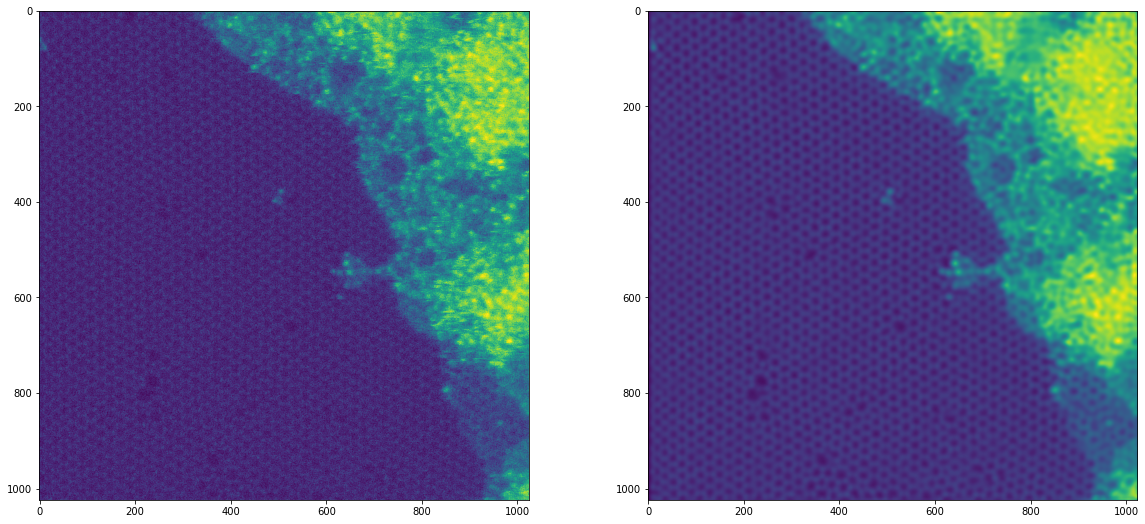

In [17]:
pred = model.predict(expdata[None, None])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(expdata)
ax2.imshow(pred.squeeze());

Looks like a decent result!